# Evaluation for the Synthetic Pendulum Experiments
This notebook can be used to load and analyze the results generated by running `training_syntheticPendulum.py`. The notebook is meant to evaluate multiple experiments together and compute the average Performances over all experiments. (E.g. the average performance over all 9 stonewall/woodwall/wallclock scenes, as reported in the papaer)

The path to the the folder containing the experiments needs to be specified under `path_experiment`. The folder set here needs to contain the subfolders with the experiments, where those subfolders need to contain `ckpt.pth` and `./hydra/`.

In [1]:
%cd ..

/home/jan/Documents/TUDelftMSc/CVDL/project/project/PhysParamInference


In [2]:
import os
import torch
import yaml
from models.sceneRepresentation import Scene
from dataset.dataset import DynamicPixelDataset, get_split_dynamic_pixel_data
from util.initialValues import estimate_initial_values
import matplotlib.pyplot as plt
from torchvision import utils
from util.util import compute_psnr, compute_iou

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [3]:
# Set the path to the experiments to analyze.
# The folder specified here needs to contain the subfolders which contain `ckpt.pth` and `./hydra/` 
path_experiments = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2024-05-20',
    'synthetic',
    'ours',
    'wallclock'
)

## Quantitative evaluation

In [4]:
param_errors = []
psnrs = []
ious = []
init_errors_A = []
init_errors_x0 = []
path_file = os.path.join(path_experiments, 'results.txt')

# Delete previous result files
if os.path.exists(path_file):
    os.remove(path_file)

# Get all the experiments
for path_experiment in os.scandir(path_experiments):
    # Load Config
    path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
    with open(path_conf) as f:
        cfg = yaml.safe_load(f)

    print("Doing: ", cfg['data']['path_data'])

    # Load Model
    model = Scene(**cfg['scene']['background'])
    model.add_pendulum(**cfg['ode'], **cfg['scene']['local_representation'])

    path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
    model.load_state_dict(torch.load(path_ckpt))

    model.to(device)

    # Load Data
    train_data, test_data = get_split_dynamic_pixel_data(**cfg['data'])
    H, W = test_data.get_image_dim()
    tspan = train_data.parameters["tspan"].to(device)

    # Compute errors of init values
    init_values_estimate = estimate_initial_values(
        train_data.get_full_mask(),
        train_data.get_pixel_coords(),
        tspan
    )
    rel_error_init_A = (torch.norm(test_data.get_image_dim()[0]*init_values_estimate['A'] - test_data.parameters['A']) /
                        torch.norm(test_data.parameters['A']))
    rel_error_init_x0 = torch.norm(init_values_estimate['x0'] - test_data.parameters['x0']) / torch.norm(test_data.parameters['x0'])
    init_errors_A.append(rel_error_init_A)
    init_errors_x0.append(rel_error_init_x0)

    # Compute Parameter Errors
    rel_error_A = torch.norm(test_data.parameters['A'] - W*model.local_representation.A.cpu()) / torch.norm(test_data.parameters['A'])
    rel_error_c = torch.abs(test_data.parameters['c'] - model.local_representation.ode.c.cpu()) / test_data.parameters['c']
    rel_error_l = torch.abs(test_data.parameters['l_pendulum'] - model.local_representation.ode.l_pendulum.cpu()) / test_data.parameters['l_pendulum']
    rel_error_x0 = torch.norm(test_data.parameters['x0'] - model.local_representation.x0.cpu()) / torch.norm(test_data.parameters['x0'])
    param_errors.append(rel_error_A)
    param_errors.append(rel_error_c)
    param_errors.append(rel_error_l)
    param_errors.append(rel_error_x0)

    # Compute PSNR and IoU
    tspan = test_data.parameters["tspan"].to(device)
    model.update_trafo(tspan)
    output = model.render_image(W, H)
    psnr = compute_psnr(output['Image'].cpu(), test_data.get_full_images())
    iou = compute_iou(output['Mask'].cpu(), test_data.get_full_mask())
    psnrs.append(psnr)
    ious.append(iou)

    # Write summary file
    with open(path_file, 'a') as f:
        f.write(f"{cfg['data']['path_data']}\n")
        f.write(f"{path_experiment.path}\n")
        f.write(f"Rel Error init A: {rel_error_init_A}\n")
        f.write(f"Rel Error init x0: {rel_error_init_x0}\n")
        f.write(f"Rel Error A: {rel_error_A}\n")
        f.write(f"Rel Error c: {rel_error_c.data}\n")
        f.write(f"Rel Error l: {rel_error_l.data}\n")
        f.write(f"Rel Error x0: {rel_error_x0}\n")
        f.write(f"PSNR: {psnr}\n")
        f.write(f"IoU: {iou}\n")
        f.write("=============================\n\n")

    mean_errors = torch.mean(torch.tensor([rel_error_A, rel_error_c, rel_error_l, rel_error_x0]))
    print(f"Mean Errors: {mean_errors}, PSNR: {psnr}, IoU: {iou}")

    print("Done")
    print("====================================================")

avg_param_error = torch.mean(torch.tensor(param_errors))
avg_init_errors_A = torch.mean(torch.tensor(init_errors_A))
avg_init_errors_x0 = torch.mean(torch.tensor(init_errors_x0))
avg_psnr = torch.mean(torch.tensor(psnrs))
avg_iou = torch.mean(torch.tensor(ious))
print("Results:")
print(f"Avg Param Error: {avg_param_error}, Avg PSNR: {avg_psnr}, Avg IoU: {avg_iou}, Avg Init Error A: {avg_init_errors_A}, Avg Init Error x0: {avg_init_errors_x0}")

# Write to results file
with open(path_file, 'a') as f:
    f.write(f"Avg Init Error A: {avg_init_errors_A}, Avg Init Error x0: {avg_init_errors_x0}\n")
    f.write("\nLatex\n")
    f.write(f"{avg_psnr:.2f} & {avg_iou:.2f} & {(100*avg_param_error):.2f}")

Doing:  synthetic_data/wallclock9


/home/jan/Documents/TUDelftMSc/CVDL/project/project/PhysParamInference/dataset/dataset.py:128: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  images = torch.tensor(
/home/jan/anaconda3/envs/physParamInference/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Mean Errors: 0.0038894619792699814, PSNR: 35.087310791015625, IoU: 0.16731058061122894
Done
Results:
Avg Param Error: 0.0038894619792699814, Avg PSNR: 35.087310791015625, Avg IoU: 0.16731058061122894, Avg Init Error A: 0.12516456842422485, Avg Init Error x0: 0.5069853067398071


## Render Images
The following code creates images for a specific experiment. The folder containing `ckpt.pth` and `./hydra/` for this experiment needs to be specified under `path_experiment`.

In [6]:
path_experiment = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2024-05-20',
    'synthetic',
    'ours',
    'wallclock',
    '22-03-12_seq9'
)

path_folder = os.path.join(path_experiment, 'renderings')
if not os.path.isdir(path_folder):
    os.makedirs(path_folder)

# Load Config
path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
with open(path_conf) as f:
    cfg = yaml.safe_load(f)

# Load Model
model = Scene(**cfg['scene']['background'])
model.add_pendulum(**cfg['ode'], **cfg['scene']['local_representation'])

path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
model.load_state_dict(torch.load(path_ckpt))

model.to(device)
print("Model loaded")

Model loaded


Data loaded
tensor([0.0000, 0.2020, 0.4040, 0.6061, 0.8081, 1.0101, 1.2121, 1.4141, 1.6162,
        1.8182, 2.0202, 2.2222, 2.4242, 2.6263, 2.8283], device='cuda:0')


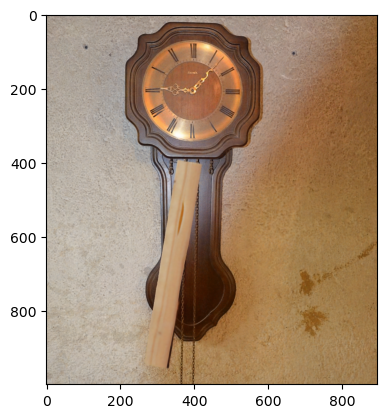

In [7]:
# Train images
# Load Data
path_data = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])
data = DynamicPixelDataset(
    path_data,
    skip_timesteps=cfg['data']['skip_timesteps'],
    max_samples=cfg['data']['max_samples']
)
H, W = data.get_image_dim()
print("Data loaded")

# Render
tspan = data.parameters["tspan"].to(device)
print(tspan)
model.update_trafo(tspan)
output = model.render_image(W, H)
ims = output["Image"].cpu()
masks = output['Mask'].cpu()

plt.imshow(ims[0])

# Train data
inds_to_save = [0, 1]

for i in inds_to_save:
    path = os.path.join(path_folder, f"{i}_train.jpg")
    utils.save_image(ims[i].permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_mask_train.jpg")
    utils.save_image(masks[i], path)
    path = os.path.join(path_folder, f"{i}_gt_train.jpg")
    utils.save_image(data.get_full_images(i).permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_mask_gt_train.jpg")
    utils.save_image(data.get_full_mask(i), path)

Data loaded
tensor([0.0000, 0.1010, 0.3030, 0.5051, 0.7071, 0.9091, 1.1111, 1.3131, 1.5152,
        1.7172, 1.9192, 2.1212, 2.3232, 2.5253, 2.7273, 2.9293, 3.1313, 3.3333,
        3.5354, 3.7374, 3.9394, 4.1414, 4.3434, 4.5455, 4.7475, 4.9495],
       device='cuda:0')
Storing at times 0.9090908765792847 and 4.3434343338012695


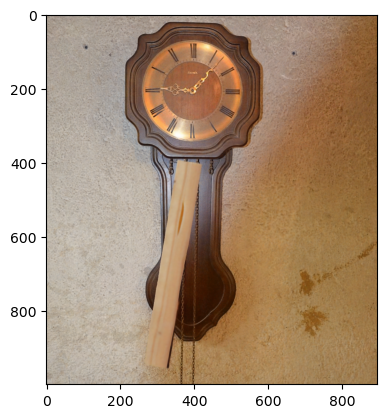

In [8]:
# Test images
# Load Data
path_data = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])
data = DynamicPixelDataset(
    path_data,
    start_index=cfg['data']['start_idx_test'],
    max_samples=cfg['data']['max_samples_eval'],
    skip_timesteps=cfg['data']['skip_timesteps'],
)
H, W = data.get_image_dim()
print("Data loaded")

# Render
tspan = data.parameters["tspan"].to(device)
print(tspan)
model.update_trafo(tspan)
output = model.render_image(W, H)
ims = output["Image"].cpu()
masks = output['Mask'].cpu()

plt.imshow(ims[0])

# Train data
inds_to_save = [5, 22]
print(f"Storing at times {tspan[inds_to_save[0]]} and {tspan[inds_to_save[1]]}")

for i in inds_to_save:
    path = os.path.join(path_folder, f"{i}_test.jpg")
    utils.save_image(ims[i].permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_mask_test.jpg")
    utils.save_image(masks[i], path)
    path = os.path.join(path_folder, f"{i}_gt_test.jpg")
    utils.save_image(data.get_full_images(i).permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_mask_gt_test.jpg")
    utils.save_image(data.get_full_mask(i), path)